In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('/kaggle/input/bitcoin-price-dataset/bitcoin_2017_to_2023.csv')

In [5]:
df.head()

,timestamp,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
0,2023-08-01 13:19:00,28902.48,28902.49,28902.48,28902.49,4.68658,1.354538e+05,258,0.89391,25836.224836
1,2023-08-01 13:18:00,28902.48,28902.49,28902.48,28902.49,4.77589,1.380351e+05,317,2.24546,64899.385195
2,2023-08-01 13:17:00,28908.52,28908.53,28902.48,28902.49,11.52263,3.330532e+05,451,2.70873,78290.170121
3,2023-08-01 13:16:00,28907.41,28912.74,28907.41,28908.53,15.89610,4.595556e+05,483,10.22981,295738.166916
4,2023-08-01 13:15:00,28896.00,28907.42,28893.03,28907.41,37.74657,1.090761e+06,686,16.50452,476955.246611


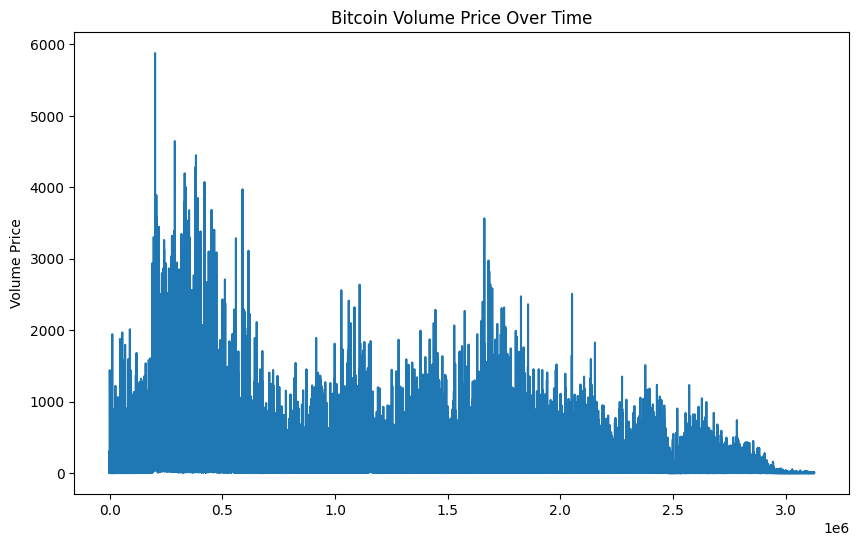

In [16]:
# Visualize the 'volume' prices over time (assuming there is an implicit date ordering)
df['volume'].plot(figsize=(10, 6))
plt.title('Bitcoin Volume Price Over Time')
plt.ylabel('Volume Price')
plt.show()


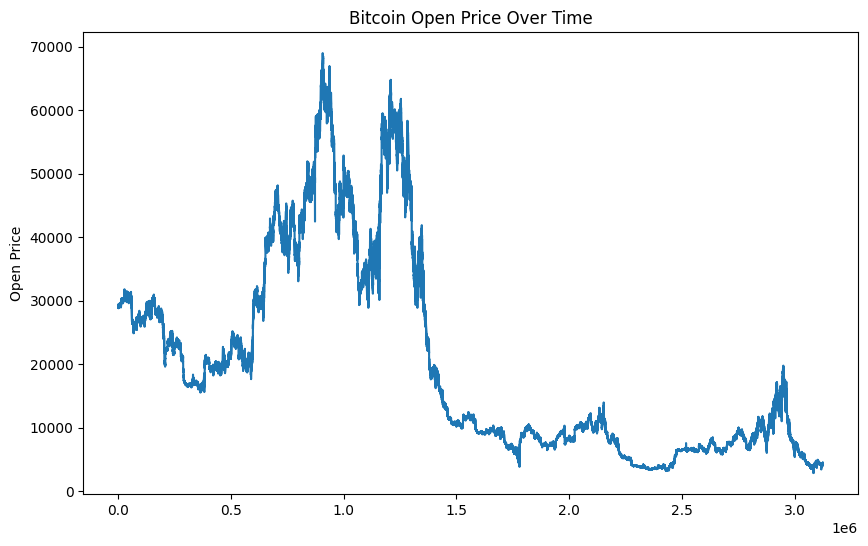

In [4]:
# Visualize the 'open' prices over time (assuming there is an implicit date ordering)
df['open'].plot(figsize=(10, 6))
plt.title('Bitcoin Open Price Over Time')
plt.ylabel('Open Price')
plt.show()


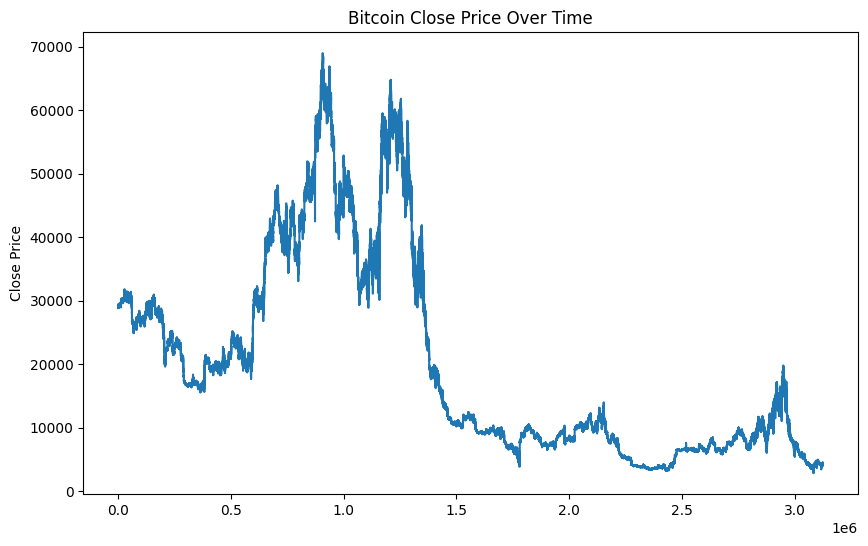

In [5]:
# Visualize the 'close' prices over time (assuming there is an implicit date ordering)
df['close'].plot(figsize=(10, 6))
plt.title('Bitcoin Close Price Over Time')
plt.ylabel('Close Price')
plt.show()


In [6]:
df = df.sample(frac=0.1, random_state=42) 

### **RNN**

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, SimpleRNN, Input, Bidirectional, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from keras_tuner import RandomSearch


Trial 5 Complete [00h 07m 41s]
val_loss: 0.06274093687534332

Best val_loss So Far: 0.06274093687534332
Total elapsed time: 00h 34m 53s

    The hyperparameter search is complete. The optimal number of RNN layers is 3.
    The optimal number of units in each RNN layer are [50, 50, 100].
    The optimal dropout rates are [0.4, 0.1, 0.30000000000000004].
    The optimal dense units in the Dense layer is 20.
    The optimal learning rate for the optimizer is 0.0001888154526950113.
    
Epoch 1/10
9765/9765 ━━━━━━━━━━━━━━━━━━━━ 60s 5ms/step - loss: 0.1010 - val_loss: 0.0629
Epoch 2/10
9765/9765 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - loss: 0.0599 - val_loss: 0.0625
Epoch 3/10
9765/9765 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - loss: 0.0597 - val_loss: 0.0627
Epoch 4/10
9765/9765 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - loss: 0.0594 - val_loss: 0.0629
Epoch 5/10
9765/9765 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - loss: 0.0594 - val_loss: 0.0630
Epoch 6/10
9765/9765 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - loss: 0.05

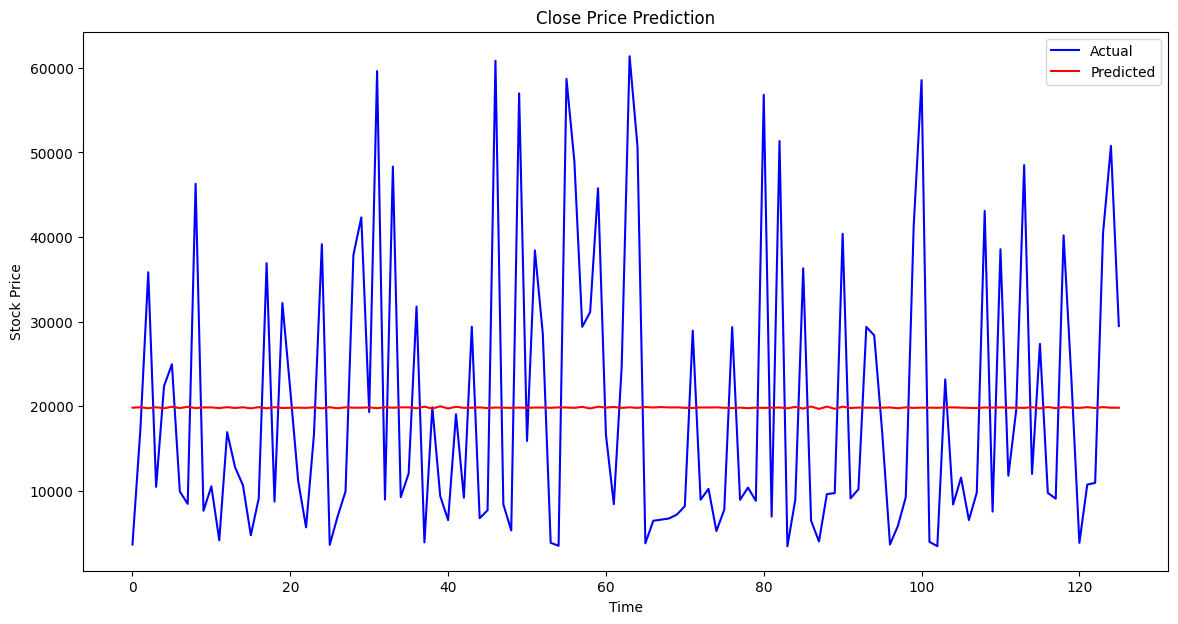

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from kerastuner import RandomSearch
from keras.models import Sequential
from keras.layers import SimpleRNN, Dropout, Dense
import tensorflow as tf  # Make sure to import TensorFlow

def build_rnn_model(hp, input_shape):
    model = Sequential()

    # Determine the number of RNN layers
    num_rnn_layers = hp.Int('num_rnn_layers', 1, 3)

    # Add RNN layers
    for i in range(num_rnn_layers):
        model.add(SimpleRNN(
            units=hp.Int(f'units_{i}', min_value=50, max_value=200, step=50),
            return_sequences=True if i < num_rnn_layers - 1 else False,
            input_shape=input_shape if i == 0 else None
        ))
        model.add(Dropout(hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)))

    # Add Dense layer
    model.add(Dense(units=hp.Int('dense_units', min_value=10, max_value=50, step=10)))

    # Add output layer
    model.add(Dense(units=1))

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
        ),
        loss='mean_squared_error'
    )

    return model

def prepare_data_for_stock(stock_data, window_size=10):
    if not isinstance(stock_data, pd.Series):
        raise ValueError("stock_data must be a Pandas Series")

    # Create lagged features
    lagged_data = pd.DataFrame({'price': stock_data})
    for i in range(1, window_size + 1):
        lagged_data[f'lag_{i}'] = lagged_data['price'].shift(i)

    lagged_data.dropna(inplace=True)

    # Features and target
    X = lagged_data.drop(columns=['price']).values
    y = lagged_data['price'].values

    # Scaling the input data
    scaler_X = MinMaxScaler()
    X = scaler_X.fit_transform(X)

    # Scaling the target variable
    scaler_y = MinMaxScaler()
    y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

    # Split into training and testing sets, using the last 6 months for testing
    test_size = 126  # Assuming 21 trading days per month, 6 months = 21 * 6
    X_train, X_test = X[:-test_size], X[-test_size:]
    y_train, y_test = y[:-test_size], y[-test_size:]

    return X_train, y_train, X_test, y_test, scaler_y

def process_stock_data_rnn(close_prices, epochs=10, batch_size=32):
    print(f"Processing close prices...")

    X_train, y_train, X_test, y_test, stock_scaler = prepare_data_for_stock(close_prices)

    # Define the input shape for the model
    input_shape = (X_train.shape[1], 1)

    # Reshape X for RNN input
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Define the tuner
    tuner = RandomSearch(
        lambda hp: build_rnn_model(hp, input_shape),
        objective='val_loss',
        max_trials=5,
        executions_per_trial=1,
        directory='hyperparam_tuning_rnn',
        project_name='rnn_close'
    )

    # Run the hyperparameter search
    tuner.search(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), batch_size=batch_size)

    # Get the best hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print(f"""
    The hyperparameter search is complete. The optimal number of RNN layers is {best_hps.get('num_rnn_layers')}.
    The optimal number of units in each RNN layer are {[best_hps.get(f'units_{i}') for i in range(best_hps.get('num_rnn_layers'))]}.
    The optimal dropout rates are {[best_hps.get(f'dropout_{i}') for i in range(best_hps.get('num_rnn_layers'))]}.
    The optimal dense units in the Dense layer is {best_hps.get('dense_units')}.
    The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
    """)

    best_model = tuner.hypermodel.build(best_hps)

    # Train the best model
    history = best_model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), batch_size=batch_size)

    # Save the best model
    best_model.save('best_rnn.h5')
    print("Best model saved as best_rnn.h5")

    y_pred = best_model.predict(X_test)

    y_pred_scaled = stock_scaler.inverse_transform(y_pred)
    y_test_scaled = stock_scaler.inverse_transform(y_test.reshape(-1, 1))

    mse = mean_squared_error(y_test_scaled, y_pred_scaled)
    mae = mean_absolute_error(y_test_scaled, y_pred_scaled)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_scaled, y_pred_scaled)

    print(f"""
    Evaluation Metrics for close prices:
    Mean Squared Error (MSE): {mse}
    Mean Absolute Error (MAE): {mae}
    Root Mean Squared Error (RMSE): {rmse}
    R² Score: {r2}
    """)

    # Plot the results
    plt.figure(figsize=(14, 7))
    plt.plot(y_test_scaled, color='blue', label='Actual')
    plt.plot(y_pred_scaled, color='red', label='Predicted')
    plt.title('Close Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

# Example usage
# Call the process function with your DataFrame
process_stock_data_rnn(df['close'])


### **LSTM**

Trial 5 Complete [00h 14m 51s]
val_loss: 0.06292656809091568

Best val_loss So Far: 0.06292401999235153
Total elapsed time: 01h 00m 26s

    The hyperparameter search is complete. The optimal number of LSTM layers is 2.
    The optimal number of units in each LSTM layer are [200, 150].
    The optimal dropout rates are [0.30000000000000004, 0.30000000000000004].
    The optimal dense units in the Dense layer is 50.
    The optimal learning rate for the optimizer is 0.0001847865399001616.
    
Epoch 1/10
9765/9765 ━━━━━━━━━━━━━━━━━━━━ 72s 7ms/step - loss: 0.0599 - val_loss: 0.0631
Epoch 2/10
9765/9765 ━━━━━━━━━━━━━━━━━━━━ 62s 6ms/step - loss: 0.0596 - val_loss: 0.0629
Epoch 3/10
9765/9765 ━━━━━━━━━━━━━━━━━━━━ 70s 7ms/step - loss: 0.0596 - val_loss: 0.0629
Epoch 4/10
9765/9765 ━━━━━━━━━━━━━━━━━━━━ 73s 7ms/step - loss: 0.0595 - val_loss: 0.0631
Epoch 5/10
9765/9765 ━━━━━━━━━━━━━━━━━━━━ 72s 7ms/step - loss: 0.0593 - val_loss: 0.0630
Epoch 6/10
9765/9765 ━━━━━━━━━━━━━━━━━━━━ 72s 7ms/step - 

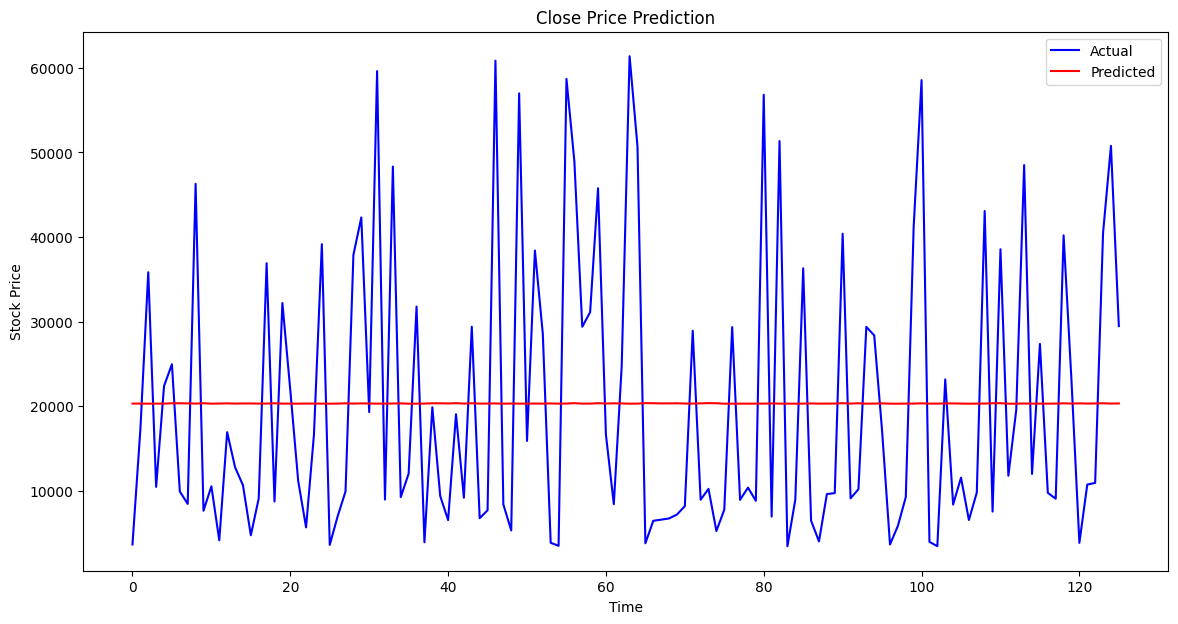

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from kerastuner import RandomSearch
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
import tensorflow as tf  # Ensure TensorFlow is imported

def build_lstm_model(hp, input_shape):
    model = Sequential()

    # Determine the number of LSTM layers
    num_lstm_layers = hp.Int('num_lstm_layers', 1, 3)

    # Add LSTM layers
    for i in range(num_lstm_layers):
        model.add(LSTM(
            units=hp.Int(f'units_{i}', min_value=50, max_value=200, step=50),
            return_sequences=True if i < num_lstm_layers - 1 else False,
            input_shape=input_shape if i == 0 else None
        ))
        model.add(Dropout(hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)))

    # Add Dense layer
    model.add(Dense(units=hp.Int('dense_units', min_value=10, max_value=50, step=10)))

    # Add output layer
    model.add(Dense(units=1))

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
        ),
        loss='mean_squared_error'
    )

    return model

def prepare_data_for_stock(stock_data, window_size=10):
    if not isinstance(stock_data, pd.Series):
        raise ValueError("stock_data must be a Pandas Series")

    # Create lagged features
    lagged_data = pd.DataFrame({'price': stock_data})
    for i in range(1, window_size + 1):
        lagged_data[f'lag_{i}'] = lagged_data['price'].shift(i)

    lagged_data.dropna(inplace=True)

    # Features and target
    X = lagged_data.drop(columns=['price']).values
    y = lagged_data['price'].values

    # Scaling the input data
    scaler_X = MinMaxScaler()
    X = scaler_X.fit_transform(X)

    # Scaling the target variable
    scaler_y = MinMaxScaler()
    y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

    # Split into training and testing sets, using the last 6 months for testing
    test_size = 126  # Assuming 21 trading days per month, 6 months = 21 * 6
    X_train, X_test = X[:-test_size], X[-test_size:]
    y_train, y_test = y[:-test_size], y[-test_size:]

    return X_train, y_train, X_test, y_test, scaler_y

def process_stock_data_lstm(close_prices, epochs=10, batch_size=32):
    print(f"Processing close prices...")

    X_train, y_train, X_test, y_test, stock_scaler = prepare_data_for_stock(close_prices)

    # Define the input shape for the model
    input_shape = (X_train.shape[1], 1)

    # Reshape X for LSTM input
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Define the tuner
    tuner = RandomSearch(
        lambda hp: build_lstm_model(hp, input_shape),
        objective='val_loss',
        max_trials=5,
        executions_per_trial=1,
        directory='hyperparam_tuning_lstm',
        project_name='lstm_close'
    )

    # Run the hyperparameter search
    tuner.search(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), batch_size=batch_size)

    # Get the best hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print(f"""
    The hyperparameter search is complete. The optimal number of LSTM layers is {best_hps.get('num_lstm_layers')}.
    The optimal number of units in each LSTM layer are {[best_hps.get(f'units_{i}') for i in range(best_hps.get('num_lstm_layers'))]}.
    The optimal dropout rates are {[best_hps.get(f'dropout_{i}') for i in range(best_hps.get('num_lstm_layers'))]}.
    The optimal dense units in the Dense layer is {best_hps.get('dense_units')}.
    The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
    """)

    best_model = tuner.hypermodel.build(best_hps)

    # Train the best model
    history = best_model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), batch_size=batch_size)

    # Save the best model
    best_model.save('best_lstm.h5')
    print("Best model saved as best_lstm.h5")

    y_pred = best_model.predict(X_test)

    y_pred_scaled = stock_scaler.inverse_transform(y_pred)
    y_test_scaled = stock_scaler.inverse_transform(y_test.reshape(-1, 1))

    mse = mean_squared_error(y_test_scaled, y_pred_scaled)
    mae = mean_absolute_error(y_test_scaled, y_pred_scaled)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_scaled, y_pred_scaled)

    print(f"""
    Evaluation Metrics for close prices:
    Mean Squared Error (MSE): {mse}
    Mean Absolute Error (MAE): {mae}
    Root Mean Squared Error (RMSE): {rmse}
    R² Score: {r2}
    """)

    # Plot the results
    plt.figure(figsize=(14, 7))
    plt.plot(y_test_scaled, color='blue', label='Actual')
    plt.plot(y_pred_scaled, color='red', label='Predicted')
    plt.title('Close Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

# Example usage
# Call the process function with your DataFrame
process_stock_data_lstm(df['close'])


### **ARIMA**

Processing close prices for ARIMA model...
ARIMA model fitted with order (5, 1, 0).

    Evaluation Metrics for close prices:
    Mean Squared Error (MSE): 444204629.55738485
    Mean Absolute Error (MAE): 19199.922153507334
    Root Mean Squared Error (RMSE): 21076.16259088416
    R² Score: -0.6262938845441697
    


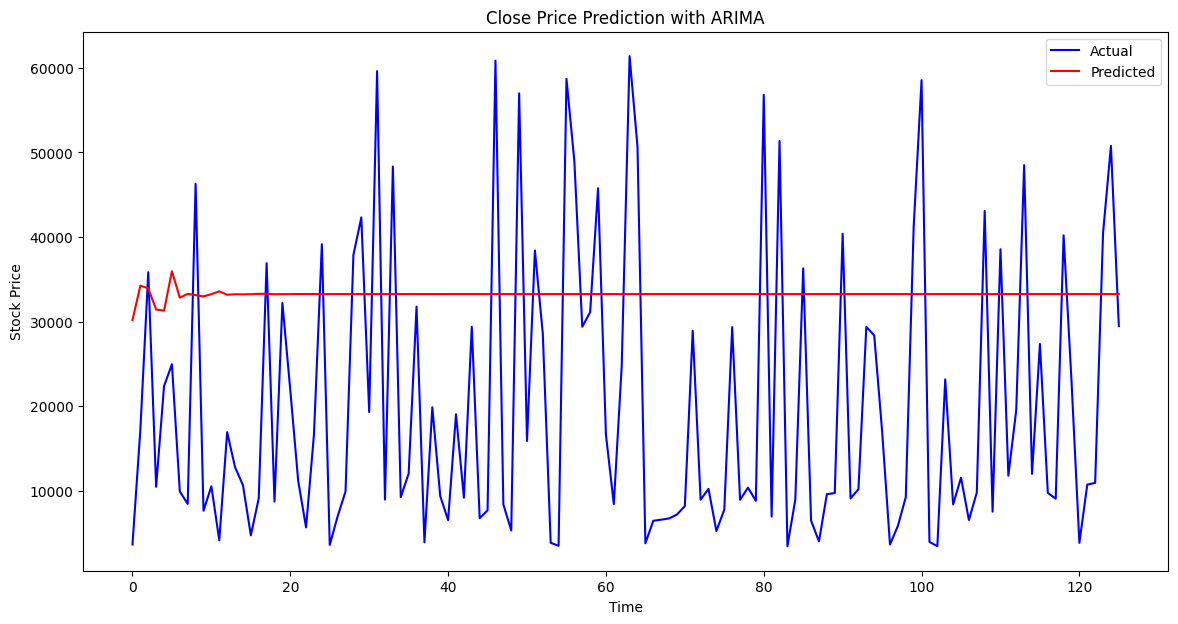

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

def prepare_data_for_arima(stock_data):
    if not isinstance(stock_data, pd.Series):
        raise ValueError("stock_data must be a Pandas Series")

    # Scaling the target variable
    scaler = MinMaxScaler()
    stock_data_scaled = scaler.fit_transform(stock_data.values.reshape(-1, 1)).flatten()

    # Split into training and testing sets, using the last 6 months for testing
    test_size = 126  # Assuming 21 trading days per month, 6 months = 21 * 6
    train_data, test_data = stock_data_scaled[:-test_size], stock_data_scaled[-test_size:]

    return train_data, test_data, scaler

def process_stock_data_arima(close_prices, order=(5, 1, 0)):
    print("Processing close prices for ARIMA model...")

    train_data, test_data, scaler = prepare_data_for_arima(close_prices)

    # Fit the ARIMA model
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()

    print(f"ARIMA model fitted with order {order}.")

    # Make predictions
    predictions = model_fit.forecast(steps=len(test_data))
    predictions_inverse = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
    test_data_inverse = scaler.inverse_transform(test_data.reshape(-1, 1)).flatten()

    # Evaluate the model
    mse = mean_squared_error(test_data_inverse, predictions_inverse)
    mae = mean_absolute_error(test_data_inverse, predictions_inverse)
    rmse = np.sqrt(mse)
    r2 = r2_score(test_data_inverse, predictions_inverse)

    print(f"""
    Evaluation Metrics for close prices:
    Mean Squared Error (MSE): {mse}
    Mean Absolute Error (MAE): {mae}
    Root Mean Squared Error (RMSE): {rmse}
    R² Score: {r2}
    """)

    # Plot the results
    plt.figure(figsize=(14, 7))
    plt.plot(test_data_inverse, color='blue', label='Actual')
    plt.plot(predictions_inverse, color='red', label='Predicted')
    plt.title('Close Price Prediction with ARIMA')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

# Example usage
# Call the process function with your DataFrame
process_stock_data_arima(df['close'])
